In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import _pickle as pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from lifelines import CoxPHFitter

In [5]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Read data

In [6]:
df = pd.read_parquet('/well/rahimi/users/sev854/project/EHRPretrain/data/BEHRT_evaluation_1.parquet/')

# TFIDF matrix

In [7]:
mp = load_obj('/well/rahimi/users/sev854/project/HFValid/data/dict/dict4code')['token2idx']
corpus = df.code.apply(lambda x: ' '.join([each for each in x if each != 'SEP' and mp.get(each, 'UNK') != 'UNK'])).values

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
col_name = vectorizer.get_feature_names_out()

# K means

14.462026119232178
32.609708309173584
43.62513589859009
33.18598508834839
47.74196767807007
57.439879417419434
52.140775203704834
64.66909980773926


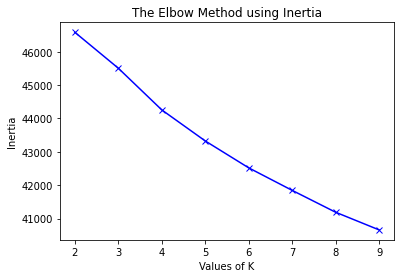

In [12]:
# inertias = []
# K = range(2, 10)

# for k in K:
#     start = time.time() 
#     # Building and fitting the model
#     kmeanModel = KMeans(n_clusters=k).fit(X)
#     inertias.append(kmeanModel.inertia_)
#     print(k, time.time()-start)
    
# plt.plot(K, inertias, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Inertia')
# plt.title('The Elbow Method using Inertia')
# plt.show()

# PCA

In [10]:
tsvd = TruncatedSVD(n_components=300)
tsvd.fit(X)

TruncatedSVD(n_components=300)

In [11]:
n = 250
print(tsvd.explained_variance_ratio_[0:n].sum())

0.7818963986367655


In [12]:
X_svd = tsvd.transform(X)[:, 0: n]

In [ ]:
# inertias = []
# K = range(1, 40)

# for k in K:
#     start = time.time() 
#     # Building and fitting the model
#     kmeanModel = KMeans(n_clusters=k).fit(X_svd)
#     inertias.append(kmeanModel.inertia_)
# #     print(k, time.time()-start)
    
# plt.plot(K, inertias, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Inertia')
# plt.title('The Elbow Method using Inertia')
# plt.show()

In [13]:
k = 8
kmeanModel = KMeans(n_clusters=k).fit(X_svd)

In [12]:
tsne=TSNE(n_components=2, learning_rate='auto', init='random')
X_embedded = tsne.fit_transform(X)
plot_df = pd.DataFrame({'X1': X_embedded[:, 0], 'X2': X_embedded[:, 1], 'cluster': kmeanModel.labels_})


In [14]:
df['label'] = kmeanModel.labels_

<AxesSubplot:xlabel='X1', ylabel='X2'>

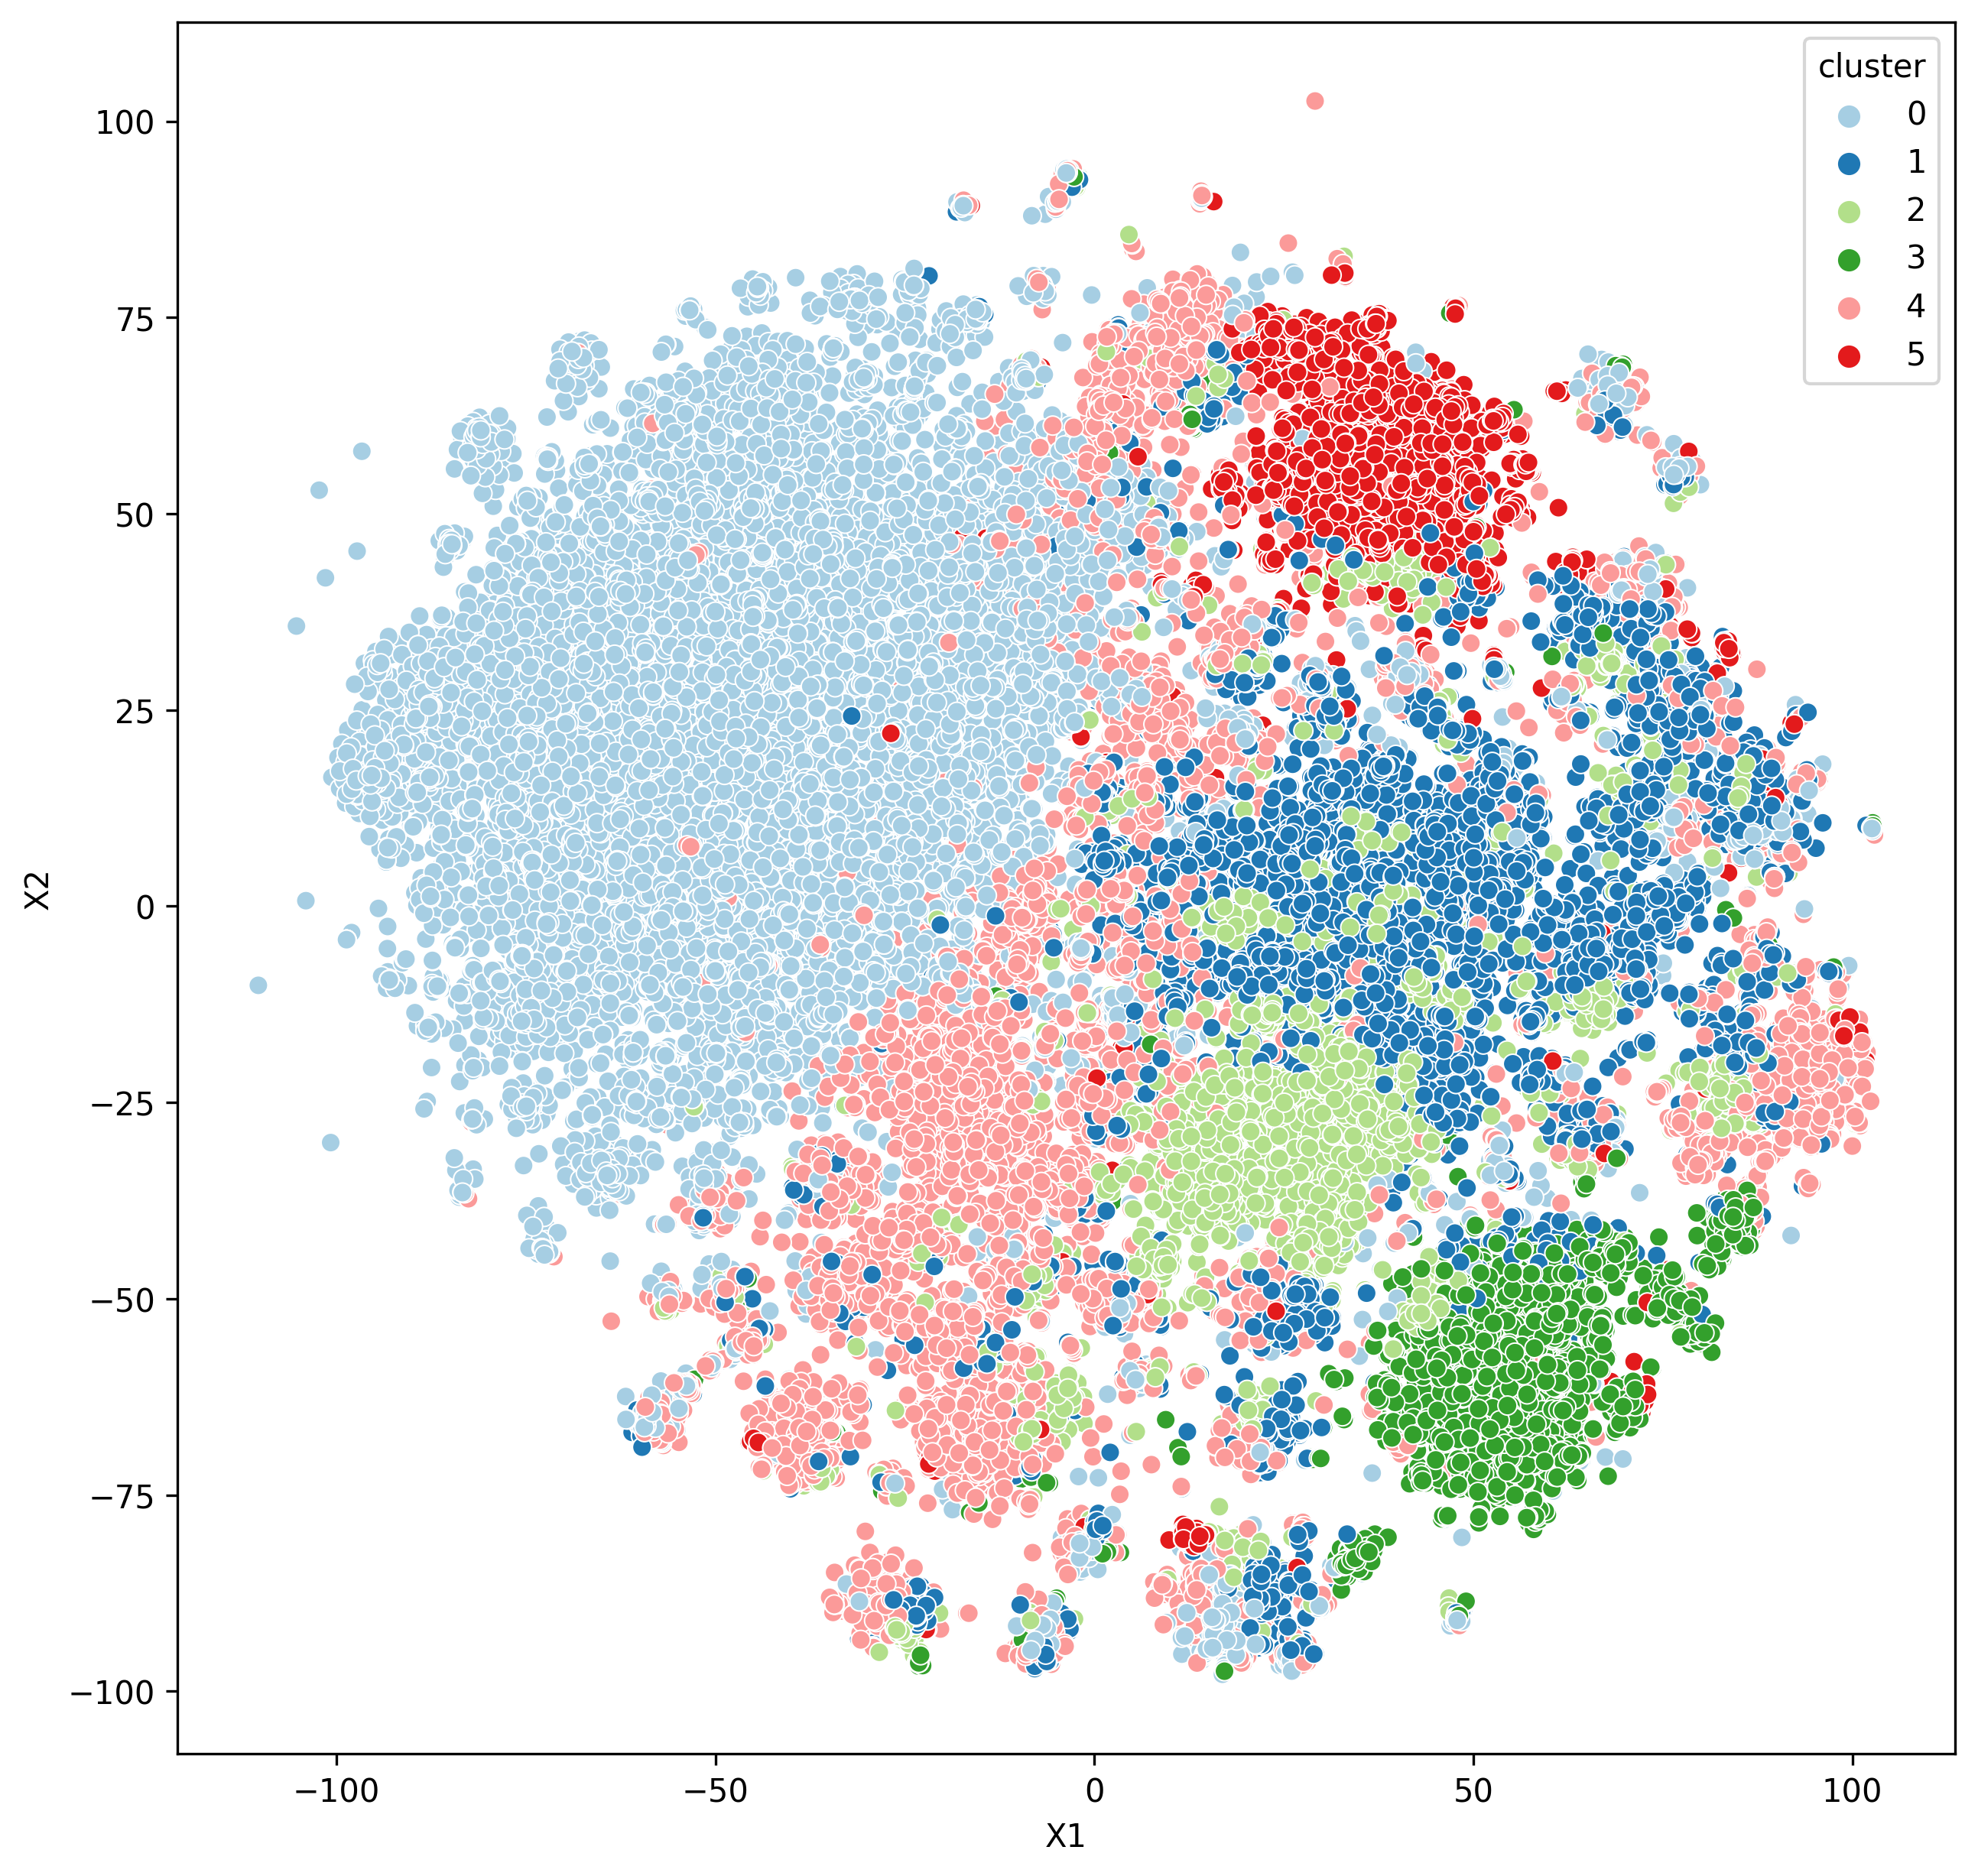

In [14]:
plt.figure(figsize=(10,10), dpi=300)
palette = sns.color_palette("Paired", k)
sns.scatterplot(data=plot_df, x="X1", y="X2", hue="cluster", palette=palette, legend='full')

In [18]:
df = df[['patid', 'event', 'time', 'label']]

df.to_parquet('/well/rahimi/users/sev854/project/EHRPretrain/data/analysis/tfidf/label.paruqet')

# pie chart

In [15]:
data = df

([<matplotlib.patches.Wedge at 0x2b1cc7ffe550>,
 [Text(0.37917843038028987, 1.0325810950885843, 'cluster 0'),
  Text(-1.0889904993262418, 0.15524075617305827, 'cluster 1'),
  Text(-0.8149401154190129, -0.7388319215361814, 'cluster 2'),
  Text(-0.3352149425115454, -1.0476788354820294, 'cluster 3'),
  Text(0.5759141235148247, -0.937188840275081, 'cluster 4'),
  Text(1.08143568101701, -0.20123833586887924, 'cluster 5')],
 [Text(0.20682459838924902, 0.5632260518665004, '38.8%'),
  Text(-0.5939948178143136, 0.0846767760943954, '17.9%'),
  Text(-0.44451279022855245, -0.40299922992882614, '10.1%'),
  Text(-0.18284451409720653, -0.5714611829901979, '6.6%'),
  Text(0.3141349764626316, -0.5111939128773169, '20.7%'),
  Text(0.5898740078274599, -0.10976636501938868, '5.9%')])

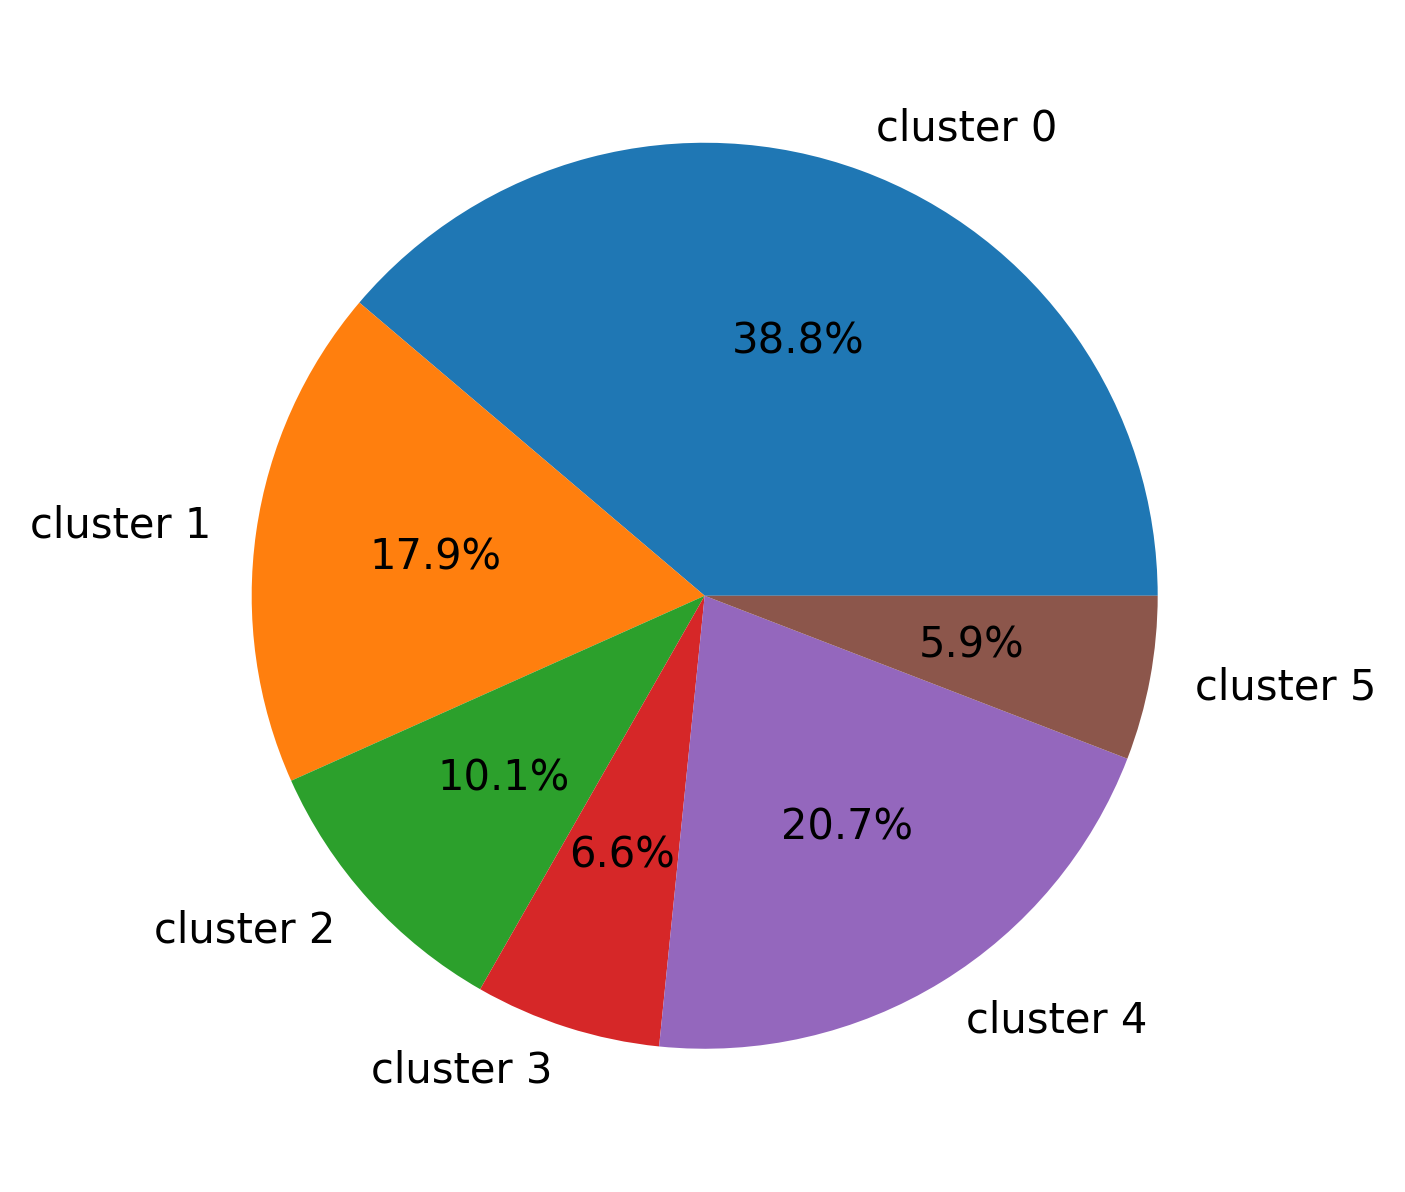

In [16]:
label = range(k)
plt.figure(figsize=(5,5), dpi=300)
pat_len = []
labels = []
for each in label:
    pat_len.append(len(data[data['label']==each]))
    labels.append('cluster {}'.format(each))
plt.pie(x=pat_len, autopct="%.1f%%", labels=labels)

# survival plot

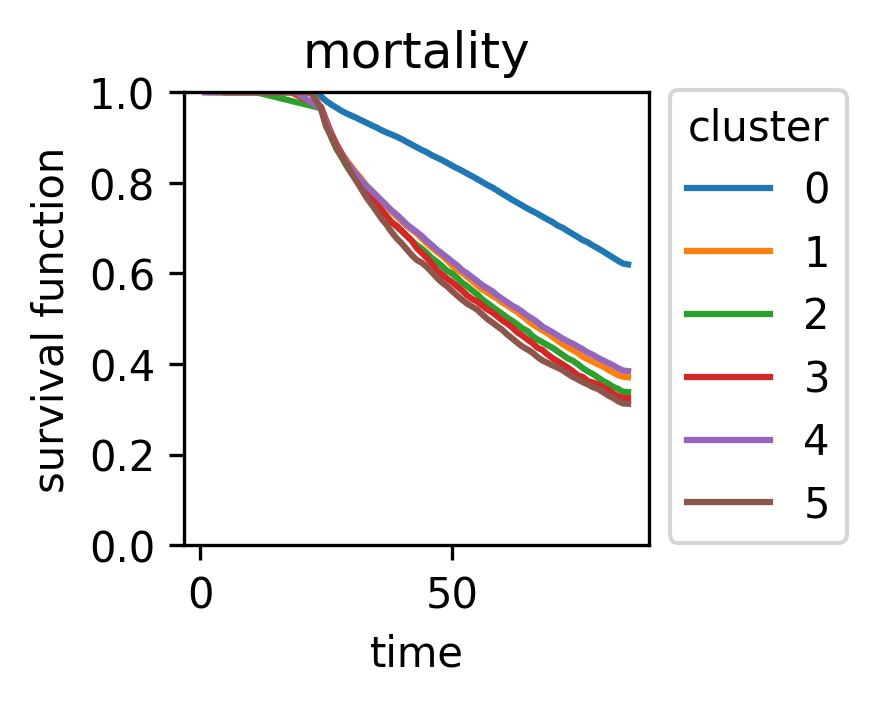

In [17]:
# label = [0, 3]

fig = plt.figure(figsize=(2,2), dpi=300)
plot_ax = {}

task_list = ['mortality']

task_map = {
    'mortality': ['event', 'time'],
}

for i, task in enumerate(task_list):
#     print(task)
    plot_ax[i] = fig.add_subplot(int('11{}'.format(i+1)))
    
    for each in label:
        train = data[data['label']==each].reset_index(drop=True)[['patid'] + [task_map[task][0], task_map[task][1]]]

#         print('group {}, number of patient: {}'.format(each, len(train)))
        cph = CoxPHFitter().fit(train, task_map[task][1], task_map[task][0])
        surv = cph.baseline_survival_
        plot_ax[i].plot(surv.index.values, surv.values, '-',label=each)
#     plot_ax[i].legend(title='cluster')
    plot_ax[i].set_title(task)
    plot_ax[i].set_ylim(0, 1)
    plot_ax[i].set_ylabel('survival function')
    plot_ax[i].set_xlabel('time')
    plot_ax[i].legend(title='cluster', bbox_to_anchor=(1., 1.05))

plt.show()

Text(0.5, 99.66666666666667, 'cluster')

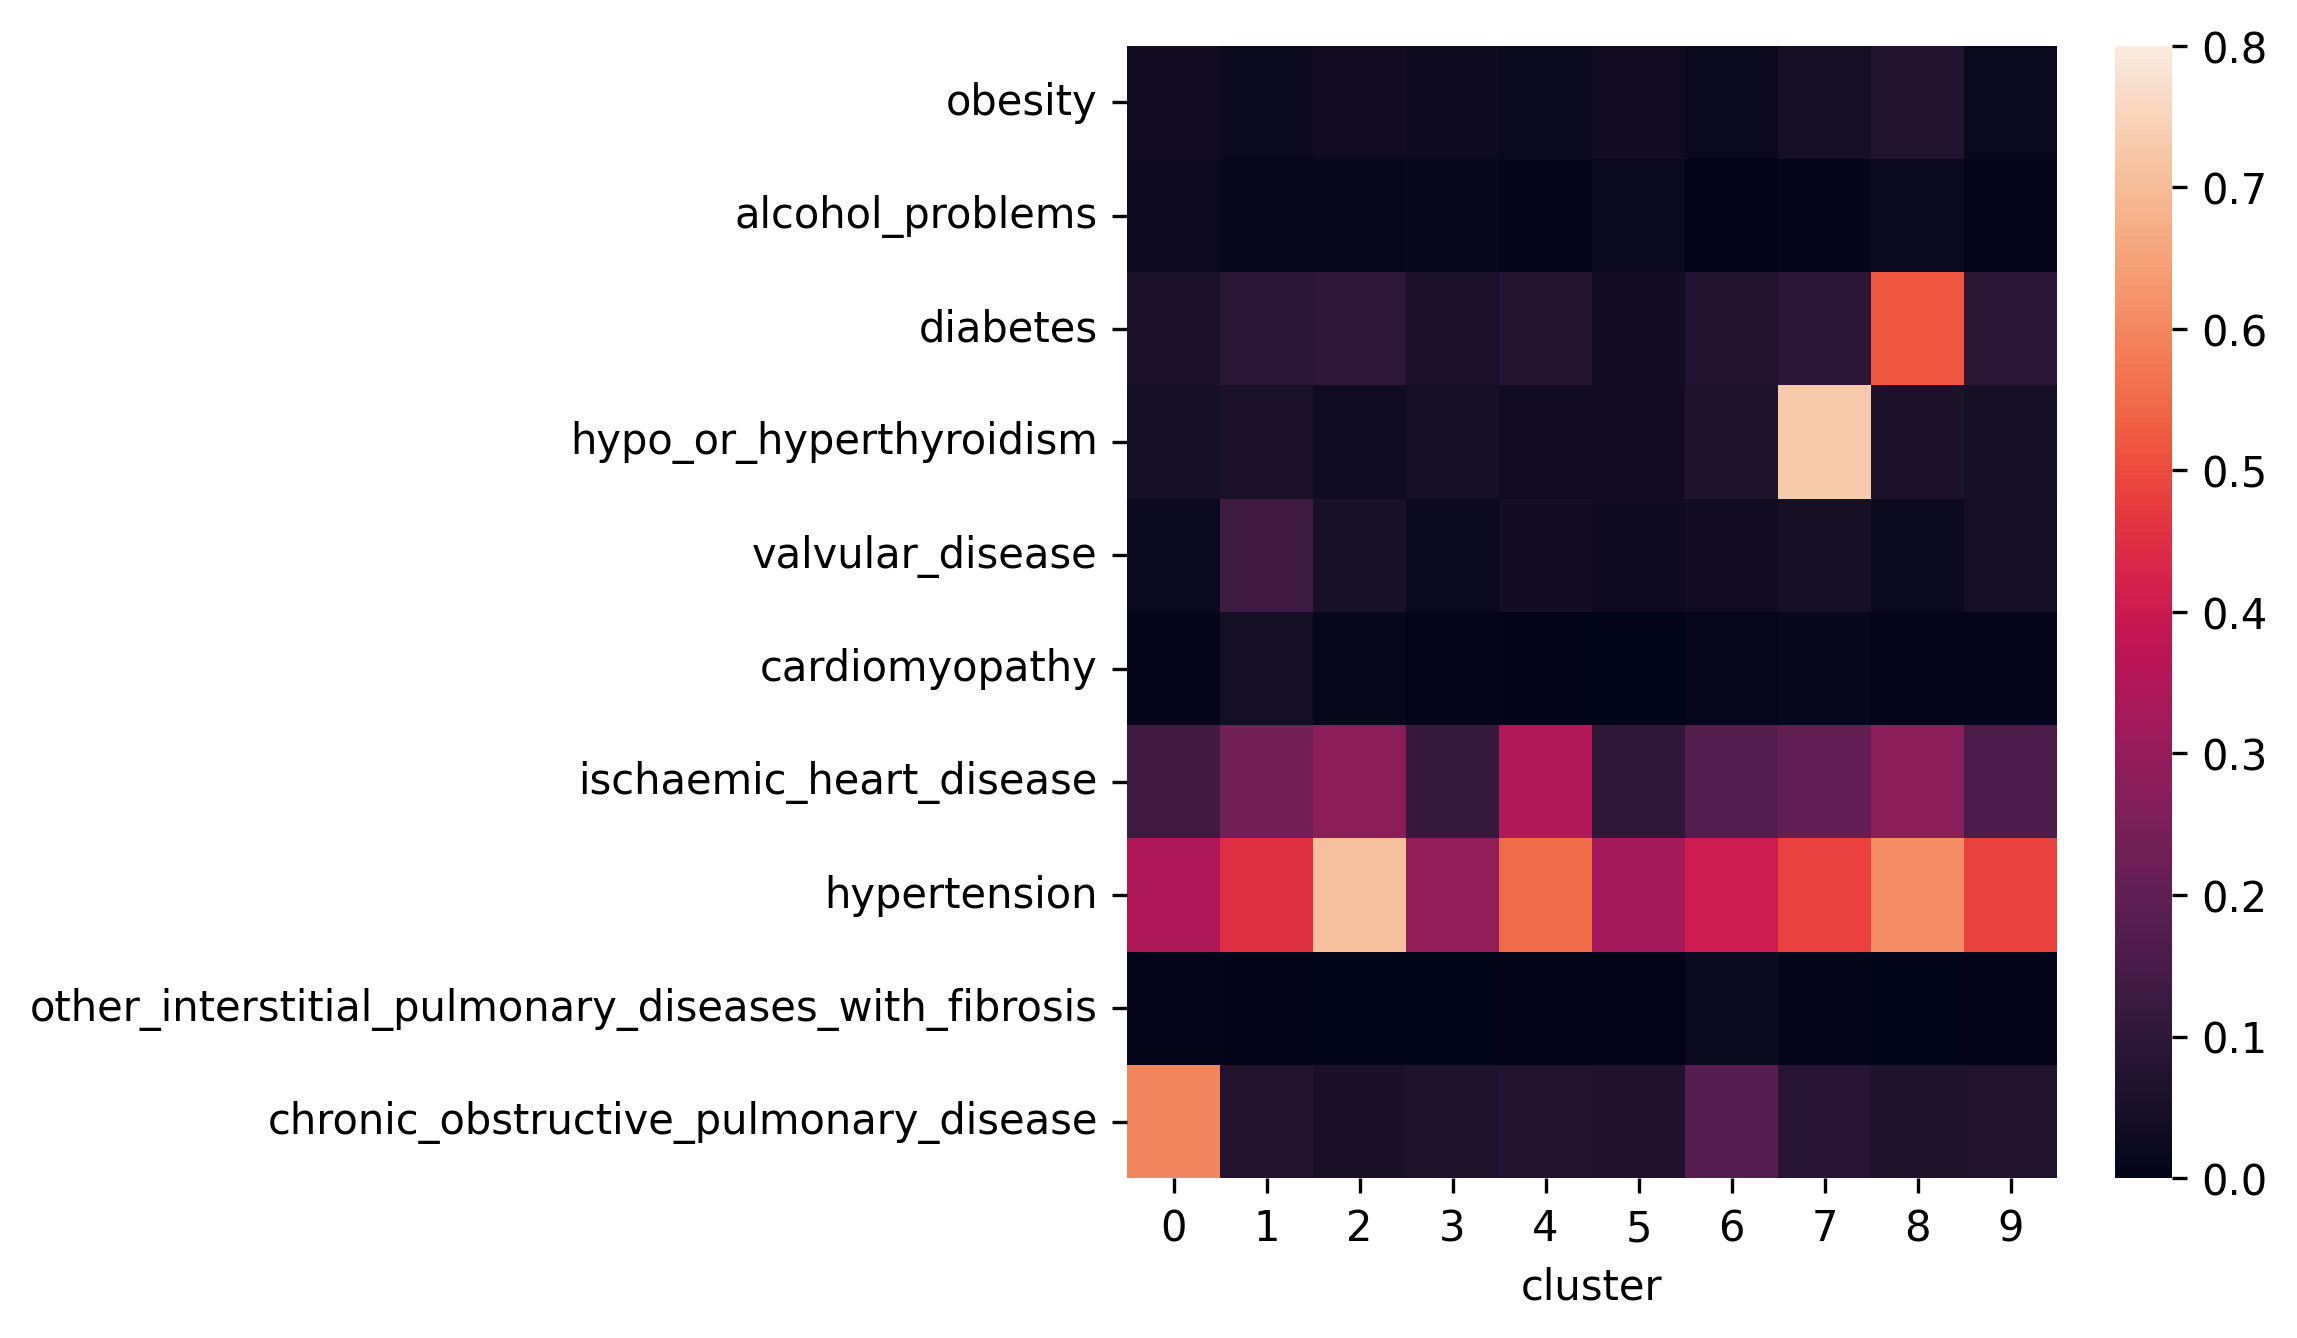

In [45]:
data = data.dropna()

feature = ['obesity', 'alcohol problems', 'diabetes', 'hypo or hyperthyroidism',
          'valvular disease', 'cardiomyopathy', 'ischaemic heart disease',
          'hypertension', 'other interstitial pulmonary diseases with fibrosis', 'chronic obstructive pulmonary disease']

feature = ['_'.join(each.split()) for each in feature]

co_matrix = []

for cluster in label:
    prev = []
    tmp = data[data['label']==cluster]
    for col in feature:
        des = tmp[col].values
        prev.append(sum(des)/len(des))
    co_matrix.append(prev)

# co prevalence matrix with row as group and col as feature
co_matrix = np.transpose(np.array(co_matrix))

plt.figure(figsize=(5,5), dpi=300)
sns.heatmap(co_matrix, xticklabels=[str(each) for each in label], yticklabels=feature, vmin=0, vmax=0.8)
plt.xlabel('cluster')